In [23]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML
import numpy as np
import math

Define the glacierSim() class

In [24]:
class glacierSim():
    def __init__(self, ela=6700,valley_length=3668, time=500,save=10,gamma=0.008, mass_balance=None):
        self.valley_length = valley_length
        self.run_time=0
        self.prev_display=0
        self.valley_height = 0
        self.start_ela = ela #in m
        self.curr_ela=ela
        self.num_cells = 50 #set number of cells
        self.dx = self.valley_length/(self.num_cells-1) #cell width in m
        self.time = time #simulation time in years
        self.save = save #timestep interval in years
        self.frames = ((int)(self.time/self.save))+1 #number of frames the animation will run for
        self.ice = np.zeros(self.num_cells) #initialize ice
        self.q = np.zeros(self.num_cells+1) #initialize ice flux, need to have num_cells+1 to offset it from ice thickness for calculations
        self.x = np.linspace(0.5 * self.dx, self.valley_length - 0.5 * self.dx,self.num_cells) #used for plotting topography and ice thickness
        self.valley_slope = [] #initialize valley slope
        self.topo = [] #initialize topography
        self.g = 9.81 #gravity constant in m/yr^2
        self.p = 917 #density of ice
        self.b_max = 0
        self.b_min = 999999999999999
        self.gamma = gamma #for mass balance equation
        # if mass_balance is None:
        #     print("Invalid mass balance input or didn't provide one, using defualt")
        #     self.b = 0.01 * (self.topo - self.ela) #initialize accumulation
        #     self.default_b = True
        # else:
        #     self.b=mass_balance
        #     self.default_b = False
        self.ice_slope = np.zeros(self.num_cells) #initialize ice_slope
    
    def init_plt(self, ax):
        ax.set_ylim(min(self.topo) - 100, max(self.topo) + 100)
        ax.set_xlim(0, self.valley_length)
        ax.set_ylabel("Height (m)")
        ax.set_xlabel("Distance (m)")
        ax.set_aspect('equal', adjustable='datalim')
        ax.plot(self.x, self.topo, color="b", label="Topography")
        
        # Initialize dynamic plot elements
        self.line, = ax.plot(self.x, self.ice + self.topo, color="c", label="Ice Thickness")
        self.ela_line = ax.axhline(y=self.start_ela, color="r", linestyle="dashed", label="ELA")  # Initialize ela_line
        
        ax.legend()
    

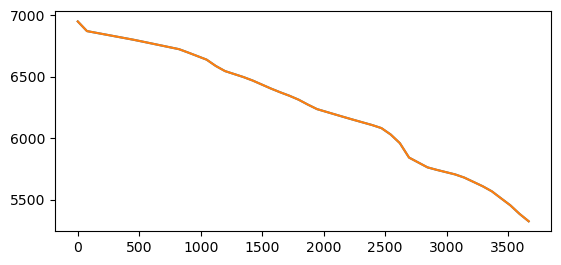

In [25]:
class glacierSim(glacierSim):
    def haversine(self, lat1, lon1, lat2, lon2):
        a = math.sin(math.radians(lat2 - lat1) / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos( math.radians(lat2)) * math.sin(math.radians(lon2 - lon1) / 2) ** 2
        return 6371000*(2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
        
    def calc_topo(self):
        latitudes = []
        longitudes = []
        with open('centerline.txt', 'r') as file:
            next(file)  # Skip the header line
            for line in file:
                fields = line.split()
                latitudes.append(float(fields[1]))    # Latitude is the second column
                longitudes.append(float(fields[2]))   # Longitude is the third column
                self.topo.append(float(fields[3]))
        cumulative_distances=[0]
        for i in range(1, len(latitudes)):
            distance = self.haversine(latitudes[i - 1], longitudes[i - 1], latitudes[i], longitudes[i]) 
            self.valley_slope.append(abs(self.topo[i-1] - self.topo[i]) / distance if distance != 0 else 0)
            cumulative_distances.append(cumulative_distances[-1] + distance)
        self.valley_height=max(self.topo)
        self.x=np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells)
        self.topo=np.interp(np.linspace(cumulative_distances[0], cumulative_distances[-1], self.num_cells), cumulative_distances, self.topo)
        self.b = 0.01 * (self.topo - self.start_ela)
        self.b = 0.01 * (self.topo - self.start_ela) #initialize accumulation
        self.default_b = True
        self.ice_slope[:-1] = abs((np.diff(self.topo)/ self.dx))
        
glac=glacierSim()
glac.calc_topo()
plt.plot(glac.x, glac.topo)
plt.plot(glac.x,glac.ice+glac.topo)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Define the snow accumulation and melt model

#### Run the model
How it works:
- The first method calc_q(self) calculates the change in ice thickness over one year
    - It calculates the ice flux using the equation above, then calculates the mass balance and combines the two to create the change in ice thickness over one year
- The second method update_ice(self,q,timestep) actually applies that change to the array holding the ice thickness values. 
- The third method report_final_values(self,u) simply prints out some statistics about the final glacier created by the model
- The last method run_model(self,i) is what actually runs the model and calculates the timestep (I got this timestep calculation idea from Professor Greg Tucker).
    - It calculates the velocity using the equation above, then uses the velocity to calculate the timestep
    - The timestep is bounded between 0.01 and 10
    - Then it uses the update function to actually update the ice thickness
    - Next it increments the current time by the timestep
    - The new ice thickness is plotted and it prints the final values of the glacier if this is the last time this function will be called

In [29]:
#Note to self: Add data about final ice thickness etc on completion of model, figure out why there are random spikes, and maybe move plotting variable initialization
class glacierSim(glacierSim):
    def calc_q(self):
        self.ice_slope[:-1] = -(np.diff(self.ice + self.topo) / self.dx) #calculate ice slope
        if np.any(np.isnan(self.ice_slope)):
            print('NaN detected in ice_slope:', self.ice_slope)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isnan(self.ice)):
            print('NaN detected in ice:', self.ice)
            print("TIME: ", self.run_time)
            return
        if np.any(np.isinf(self.ice_slope)):
            print('Infinity detected in ice_slope:', self.ice_slope)
            print('Ice: ',self.ice)
            print("TIME: ", self.run_time)
            return
        #self.q[1:]= ((2*7e-17)/5)*((self.p*self.g*self.ice_slope)**2)*(((self.ice)**5)/5)
        # self.q[1:] += 1e-6 
        #self.q[1:]= (7e-17/5)*((self.p*self.g*self.ice_slope)**3)*(self.ice**5) 
        self.q[1:] = (0.2 *(24e-25*2) * (self.p * self.g)**2)  * 31557600 * self.ice_slope**2 * (self.ice**5)/5
        if np.any(np.isnan(self.q)):
            print('NaN detected in q:', self.q)
            print(self.ice_slope)
            print(self.ice)
            print("TIME: ", self.run_time)
            return
        if(self.default_b):    
            # self.b = self.gamma * ((self.topo + self.ice) - self.ela) #calculate mass balance based on ice elevation, ela and gamma
            # b_eff = self.b 
            # below_ela=self.b<=0
            #b_eff[below_ela] = np.minimum(0,b_eff[below_ela])
            #b_eff[below_ela] = np.minimum(0, self.b[below_ela] * (1 - np.exp(-self.ice[below_ela] / self.gamma))) #find which values are below ela and calculate the ice melting for them
            self.curr_ela = self.start_ela + 500 * np.sin(2 * np.pi * self.run_time / self.time)

            # Historical variability for the past 10,000 years
            temperature_variability = 100 * np.sin(2 * np.pi * self.run_time / 1000)
            precipitation_variability = 1.2 + 0.3 * np.sin(2 * np.pi * self.run_time / 5000)

            adjusted_ela = self.curr_ela + temperature_variability
            self.b = self.gamma * (self.topo - adjusted_ela) * precipitation_variability

            # Clip for realistic mass balance values
            self.b = np.clip(self.b, -10, 5)
            if(np.max(self.b)>self.b_max):
                self.b_max = np.max(self.b)
            if(np.min(self.b)<self.b_min):
                self.b_min = np.min(self.b)
        else:  
            b_eff=self.b[:,0]
            b_eff[((self.topo + self.ice) - self.curr_ela)<0] = self.b[(((self.topo + self.ice) - self.curr_ela)<0),1]
        if (self.prev_display==0 or self.run_time>=self.prev_display+self.save) and self.run_time<self.time:
            print("TIME: ", self.run_time)
            print("ELA: ", self.curr_ela)
            print("ICE: ",self.ice)
            print("SLOPE: ",self.ice_slope)
            print("MASS BALANCE: ", self.b)
            print("Q: ",self.q)
            self.prev_display=self.run_time
        return self.ice_slope,(self.b-(np.diff(self.q)/self.dx)) #calculate the change in ice thickness and return it
        #return self.ice_slope,((np.diff(self.q)/self.dx))         

    def update_ice(self,dqdx,timestep):
        self.ice+=dqdx*timestep
        #self.ice[self.ice < 1e-10] = 0.0
        self.ice = np.maximum(self.ice,0.0)

    def report_final_values(self,u):
        ice_extent = self.x[self.ice > 0.1]
        if ice_extent.size > 0:
            print("Final glacier length: " + str(np.max(ice_extent)) + 'm')
        else:
            print("Final glacier length: 0m (no ice extent)")
        print("Final max ice thickness: " + str(np.max(self.ice)) + 'm')
        print('Final max velocity: ' +str(np.max(u)) + "m/yr")
        if(self.default_b):
            print('B min: ' + str(self.b_min))
            print('B max: ' + str(self.b_max))

    def run_model(self,i):
        #print(self.ice)
        current_time=0
        # if self.line is not None:
        #     self.line.set_data(self.x, (self.ice))
        # else:
        #     self.line, = ax.plot(self.x, (self.ice), color="c")
        if self.line is not None:
            self.line.set_data(self.x, self.ice + self.topo)
        if self.ela_line is not None:
            self.ela_line.set_ydata([self.curr_ela])  # Update ELA y-position
        timestep=0
        while(current_time<(self.save-timestep)):
            ice_slope,dqdx=self.calc_q() #type:ignore
            #u = 2/3*((model.p*model.g*(model.ice**2)*np.sin(ice_slope))/(2*1e13))*365*24*3600 #other velocity equation I tried, it didn't work
            #u = (24e-25)*((self.p*self.g*ice_slope)**3)*(((self.ice)**4)/5)
            u=(2*24e-25*3600*24*365.25)/4*(self.p*self.g*3600*24*365.25*np.sin(self.ice_slope)*self.ice)**3*self.ice
            # if(np.max(u)==0): timestep = 0.01
            # elif((self.dx/np.max(u)*.2)<0.01 or math.isnan((self.dx/np.max(u)*.2))): timestep = 0.01
            # elif((self.dx/np.max(u)*.2)>10): timestep = 10
            # else: timestep = ((self.dx/np.max(u))*.2) 
            timestep = np.clip(((self.dx / np.maximum(np.max(u), 1e-5))*0.2), 0.01, 10)
            #print(timestep, self.dx/np.max(u))
            self.ice+=np.maximum(dqdx*timestep,0.0)
            #self.ice = np.maximum(self.ice,0.0)
            current_time+=timestep
            self.run_time+=timestep
            # self.ela_line.remove()  # Remove the old line
            # self.ela_line = ax.axhline(y=self.curr_ela, color="r", linestyle="dashed", label="ELA")
            
        ice_slope,dqdx=self.calc_q() #type:ignore
        self.update_ice(dqdx,(self.save-current_time))
        current_time+=self.save-current_time
        self.run_time=current_time*i
        #obj = ax.plot(self.x,(self.ice),color="c")
        ax.set_title('Time = ' + str(round(current_time*i)) + ' years')
        if(round(current_time*i)==self.time):
            self.report_final_values(u) #type:ignore
        return [self.line, self.ela_line]

#Initialize plotting stuff outside of class
fig, ax = plt.subplots() #initialize plotting variables
_ = plt.close(fig) #used to prevent an empty plot from displaying

#### Results
This is the model with the standard inputs

In [30]:
model = glacierSim(ela=6700, time=10000, save=100)
model.calc_topo()
model.init_plt(ax)
#print(model.dx)
anim = FuncAnimation(fig, model.run_model, model.frames, blit = True)
vid = HTML(anim.to_jshtml())
print("ICE: ",model.ice)
print("SLOPE: ",model.ice_slope)
print("MASS BALANCE: ",model.b)
print("DONE")
#anim.save('animation.mp4', writer='ffmpeg', fps=15, dpi=100)
vid

TIME:  0
ELA:  6700.0
ICE:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
SLOPE:  [1.04918626 0.18578159 0.18578159 0.18578159 0.18578159 0.18578159
 0.20405275 0.2075337  0.2075337  0.2075337  0.2075337  0.36874632
 0.3848285  0.3848285  0.68914585 0.55423615 0.32408842 0.32408842
 0.37625425 0.43845887 0.43845887 0.40366988 0.3754984  0.42761637
 0.53219581 0.49215329 0.29508259 0.29508259 0.29508259 0.28753518
 0.28151358 0.28151358 0.32899214 0.69133609 0.94202816 1.56815901
 0.53077092 0.53077092 0.27155823 0.24742831 0.24742831 0.34514267
 0.47059687 0.47059687 0.55505579 0.76021327 0.75196268 0.93055327
 0.81107727 0.        ]
MASS BALANCE:  [  2.40288      1.64890477   1.51539681   1.38188886   1.2483809
   1.11487294   0.98136498   0.83472684   0.6855872    0.53644755
   0.38730791   0.23816827  -0.02682337  -0.30337213  -0.57992088
  -1.07516079  -1.47345072  -1.7063499

What happens if we change the ELA of the valley?

In [28]:
model = glacierSim(ela=666)
anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init_plt(ax), blit = True)
vid = HTML(anim.to_jshtml())
vid

ValueError: min() arg is an empty sequence

What happens if we lengthen the valley and run the model for longer?

In [ ]:
model = glacierSim(valley_length=20000, time=1000)
anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init_plt(ax), blit = True)
vid = HTML(anim.to_jshtml())
vid

What happens if we change the mass balance to accumulate 3m/yr above the ela and melt 0.5m/yr below the ela

In [ ]:

b = np.zeros((50,2))
for i in range (50):
    b[i] = np.array([5,-2])
model = glacierSim(time=1000, mass_balance=b, valley_length=20000)
anim = FuncAnimation(fig, model.run_model, model.frames, init_func=model.init_plt(ax), blit = True)
vid = HTML(anim.to_jshtml())
vid

ValueError: min() arg is an empty sequence

Feel free to copy one of the above code cells and change the input variables yourself

#### Discussion
What I've found from playing around with the model is that slightly changing a variable can have a large impact on the outcome of the model. For instance lowering the ELA by 100m doubles the length of the glacier and quadruples the max speed of the glacier which is quite remarkable. Doubling the length of the valley increased the max length by 3 times and the max speed by 4 times. I was honestly quite surprised at how much changing these variables could have a significant impact on the outcome of the model. Some further improvements that I would like to make are making the model 2D using landlab, and making it even more customizable by letting the user input their own topography and making the custom mass balance more user friendly. 